# Making Complex Decision

Reference:
*   Stuart Russell and Peter Norvig. Artificial Intelligence: A Modern Approach. 3rd Ed. (Ch. 17) [here](http://aima.cs.berkeley.edu/3rd-ed/)



## Overview

- A stochastic process has the **Markov property** if the conditional probability distribution of future states of the process (conditional on both past and present states) depends only upon the present state, not on the sequence of events that preceded it. Often it is possible to model many different phenomena as a Markov process by being flexible with our definition of state.
   
- MDPs help us deal with fully-observable and non-deterministic/stochastic environments. For dealing with partially-observable and stochastic cases we make use of generalization of MDPs named POMDPs (partially observable Markov decision process).

- Our overall goal to solve a MDP is to come up with a policy which guides us to select the best action in each state so as to maximize the expected sum of future rewards.

In [30]:
import random
from collections import defaultdict

import numpy as np

In [31]:
# several utility code
import operator

def vector_add(a, b):
    """Component-wise addition of two vectors."""
    return tuple(map(operator.add, a, b))

orientations = EAST, NORTH, WEST, SOUTH = [(1, 0), (0, 1), (-1, 0), (0, -1)]
turns = LEFT, RIGHT = (+1, -1)

def turn_heading(heading, inc, headings=orientations):
    return headings[(headings.index(heading) + inc) % len(headings)]

def turn_right(heading):
    return turn_heading(heading, RIGHT)

def turn_left(heading):
    return turn_heading(heading, LEFT)

def isnumber(x):
    """Is x a number?"""
    return hasattr(x, '__int__')

In [69]:
# utility class matrix
class Matrix:
    """Matrix operations class"""

    @staticmethod
    def add(A, B):
        """Add two matrices A and B"""

        res = []
        for i in range(len(A)):
            row = []
            for j in range(len(A[0])):
                row.append(A[i][j] + B[i][j])
            res.append(row)
        return res

    @staticmethod
    def scalar_multiply(a, B):
        """Multiply scalar a to matrix B"""

        for i in range(len(B)):
            for j in range(len(B[0])):
                B[i][j] = a * B[i][j]
        return B

    @staticmethod
    def multiply(A, B):
        """Multiply two matrices A and B element-wise"""

        matrix = []
        for i in range(len(B)):
            row = []
            for j in range(len(B[0])):
                row.append(B[i][j] * A[j][i])
            matrix.append(row)

        return matrix

    @staticmethod
    def matmul(A, B):
        """Inner-product of two matrices"""

        return [[sum(ele_a * ele_b for ele_a, ele_b in zip(row_a, col_b)) for col_b in list(zip(*B))] for row_a in A]

    @staticmethod
    def transpose(A):
        """Transpose a matrix"""

        return [list(i) for i in zip(*A)]

## Markov Decision Processes (MDP)

A Markov Decision Process, defined by an initial state, transition model, and reward function. We also keep track of a γ value, for use by algorithms. The transition model is represented somewhat differently from the text. Instead of $P(s' | s, a)$ being a probability number for each state/state/action triplet, we instead have $T(s, a)$ return a list of $(p, s')$ pairs. We also keep track of the possible states, terminal states, and actions for each state.

In [32]:
class MDP:
    def __init__(self, init, actlist, terminals, transitions=None, reward=None, states=None, gamma=0.9):
        if not (0 < gamma <= 1):
            raise ValueError("An MDP must have 0 < gamma <= 1")

        # collect states from transitions table if not passed.
        self.states = states or self.get_states_from_transitions(transitions)

        self.init = init

        if isinstance(actlist, list):
            # if actlist is a list, all states have the same actions
            self.actlist = actlist

        elif isinstance(actlist, dict):
            # if actlist is a dict, different actions for each state
            self.actlist = actlist

        self.terminals = terminals
        self.transitions = transitions or {}
        if not self.transitions:
            print("Warning: Transition table is empty.")

        self.gamma = gamma

        self.reward = reward or {s: 0 for s in self.states}

    def R(self, state):
        """Return a numeric reward for this state."""
        
        return self.reward[state]

    def T(self, state, action):
        """Transition model. From a state and an action, return a list
        of (probability, result-state) pairs."""

        if not self.transitions:
            raise ValueError("Transition model is missing")
        else:
            return self.transitions[state][action]

    def actions(self, state):
        """Return a list of actions that can be performed in this state. By default, a
        fixed list of actions, except for terminal states. Override this
        method if you need to specialize by state."""

        if state in self.terminals:
            return [None]
        else:
            return self.actlist

    def get_states_from_transitions(self, transitions):
        if isinstance(transitions, dict):
            s1 = set(transitions.keys())
            s2 = set(tr[1] for actions in transitions.values()
                     for effects in actions.values()
                     for tr in effects)
            return s1.union(s2)
        else:
            print('Could not retrieve states from transitions')
            return None

    def check_consistency(self):

        # check that all states in transitions are valid
        assert set(self.states) == self.get_states_from_transitions(self.transitions)

        # check that init is a valid state
        assert self.init in self.states

        # check reward for each state
        assert set(self.reward.keys()) == set(self.states)

        # check that all terminals are valid states
        assert all(t in self.states for t in self.terminals)

        # check that probability distributions for all actions sum to 1
        for s1, actions in self.transitions.items():
            for a in actions.keys():
                s = 0
                for o in actions[a]:
                    s += o[0]
                assert abs(s - 1) < 0.001

The `__init__` method takes in the following parameters:
- `init`: the initial state.
- `actlist`: List of actions possible in each state.
- `terminals`: List of terminal states where only possible action is exit
- `gamma`: Discounting factor, γ. This makes sure that delayed rewards have less value compared to immediate ones.

`R` method returns the reward for each state by using the self.reward dict.

`T` method is not implemented and is somewhat different from the text. Here we return (probability, $s'$) pairs where s' belongs to list of possible state by taking action a in state $s$.

`actions` method returns list of actions possible in each state. By default it returns all actions for states other than terminal states.


Now let us implement the simple MDP in the image below. States $A$, $B$ have actions $X$, $Y$, respectively available in them. Their probabilities are shown just above the arrows. We start with using MDP as base class for our `CustomMDP`. Obviously we need to make a few changes to suit our case. We make use of a transition matrix as our transitions are not very simple.

![An Example of MDP Model](https://drive.google.com/uc?export=view&id=11tvMPYonvMV21wG_wbqi_IQtxbBNxGeJ)

In [33]:
# Transition Matrix as nested dict. State -> Actions in state -> List of (Probability, State) tuples
t = {
    "A": {
            "X": [(0.3, "A"), (0.7, "B")],
            "Y": [(1.0, "A")]
         },
    "B": {
            "X": {(0.8, "End"), (0.2, "B")},
            "Y": {(1.0, "A")}
         },
    "End": {}
}

init = "A"

terminals = ["End"]

rewards = {
    "A": 5,
    "B": -10,
    "End": 100
}

In [34]:
class CustomMDP(MDP):
    def __init__(self, init, terminals, transition_matrix, reward = None, gamma=.9):
        # All possible actions.
        actlist = []
        for state in transition_matrix.keys():
            actlist.extend(transition_matrix[state])
        actlist = list(set(actlist))
        MDP.__init__(self, init, actlist, terminals, transition_matrix, reward, gamma=gamma)

    def T(self, state, action):
        if action is None:
            return [(0.0, state)]
        else: 
            return self.t[state][action]

Finally we instantize the class with the parameters for our MDP in the picture.

In [35]:
our_mdp = CustomMDP(init, terminals, t, rewards, gamma=.9)

## Grid MDP

Now we look at a concrete implementation that makes use of the MDP as base class. The `GridMDP` class in the mdp module is used to represent a grid world MDP like the $4 x 3$ environment of the Book. We assume for now that the environment is _fully observable_, so that the agent always knows where it is. The code should be easy to understand if you have gone through the `CustomMDP` example.

In [36]:
class GridMDP(MDP):
    """A two-dimensional grid MDP. All you have to do is specify the grid 
    as a list of lists of rewards; use None for an obstacle (unreachable state). 
    Also, you should specify the terminal states. 
    An action is an (x, y) unit vector; e.g. (1, 0) means move east."""

    def __init__(self, grid, terminals, init=(0, 0), gamma=.9):
        grid.reverse()  # because we want row 0 on bottom, not on top
        reward = {}
        states = set()
        self.rows = len(grid)
        self.cols = len(grid[0])
        self.grid = grid
        for x in range(self.cols):
            for y in range(self.rows):
                if grid[y][x]:
                    states.add((x, y))
                    reward[(x, y)] = grid[y][x]
        self.states = states
        actlist = orientations
        transitions = {}
        for s in states:
            transitions[s] = {}
            for a in actlist:
                transitions[s][a] = self.calculate_T(s, a)
        MDP.__init__(self, init, actlist=actlist,
                     terminals=terminals, transitions=transitions,
                     reward=reward, states=states, gamma=gamma)

    def calculate_T(self, state, action):
        if action:
            return [(0.8, self.go(state, action)),
                    (0.1, self.go(state, turn_right(action))),
                    (0.1, self.go(state, turn_left(action)))]
        else:
            return [(0.0, state)]

    def T(self, state, action):
        return self.transitions[state][action] if action else [(0.0, state)]

    def go(self, state, direction):
        """Return the state that results from going in this direction."""

        state1 = vector_add(state, direction)
        return state1 if state1 in self.states else state

    def to_grid(self, mapping):
        """Convert a mapping from (x, y) to v into a [[..., v, ...]] grid."""

        return list(reversed([[mapping.get((x, y), None)
                               for x in range(self.cols)]
                              for y in range(self.rows)]))

    def to_arrows(self, policy):
        chars = {(1, 0): '>', (0, 1): '^', (-1, 0): '<', (0, -1): 'v', None: '.'}
        return self.to_grid({s: chars[a] for (s, a) in policy.items()})


The `__init__` method takes `grid` as an extra parameter compared to the MDP class. The grid is a nested list of rewards in states.

`go` method returns the state by going in particular direction by using vector_add.

`T` method is not implemented and is somewhat different from the text. Here we return (probability, $s'$) pairs where $s'$ belongs to list of possible state by taking action a in state $s$.

`actions` method returns list of actions possible in each state. By default it returns all actions for states other than terminal states.

`to_arrows` are used for representing the policy in a grid like format.

In [37]:
# A 4x3 grid environment that presents the agent with a sequential decision problem (as the book)

sequential_decision_environment = GridMDP([[-0.04, -0.04, -0.04, +1],
                                           [-0.04, None, -0.04, -1],
                                           [-0.04, -0.04, -0.04, -0.04]],
                                          terminals=[(3, 2), (3, 1)])

## Value Iteration

Now that we have looked how to represent MDPs. Let's aim at solving them. Our ultimate goal is to obtain an optimal policy. We start with looking at *Value Iteration* and a visualisation that should help us understanding it better.

We start by calculating Value/Utility for each of the states. The Value of each state is the expected sum of discounted future rewards given we start in that state and follow a particular policy $\pi$. The value or the utility of a state is given by

$$U(s)=R(s)+\gamma\max_{a\epsilon A(s)}\sum_{s'} P(s'\ |\ s,a)U(s')$$

This is called **the Bellman equation**. The algorithm Value Iteration relies on finding solutions of this Equation. The intuition Value Iteration works is because values propagate through the state space by means of local updates. This point will we more clear after we encounter the visualisation.

In [38]:
def value_iteration(mdp, epsilon=0.001):
    """Solving an MDP by value iteration."""

    U1 = {s: 0 for s in mdp.states}
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    while True:
        U = U1.copy()
        delta = 0
        for s in mdp.states:
            U1[s] = R(s) + gamma * max(sum(p * U[s1] for (p, s1) in T(s, a))
                                       for a in mdp.actions(s))
            delta = max(delta, abs(U1[s] - U[s]))
        if delta <= epsilon * (1 - gamma) / gamma:
            return U

In [39]:
def best_policy(mdp, U):
    """Given an MDP and a utility function U, determine the best policy,
    as a mapping from state to action."""

    pi = {}
    for s in mdp.states:
        pi[s] = max(mdp.actions(s), key=lambda a: expected_utility(a, s, U, mdp))
    return pi

It takes as inputs two parameters, an MDP to solve and epsilon, the maximum error allowed in the utility of any state. It returns a dictionary containing utilities where the keys are the states and values represent utilities. <br> Value Iteration starts with arbitrary initial values for the utilities, calculates the right side of the Bellman equation and plugs it into the left hand side, thereby updating the utility of each state from the utilities of its neighbors. 
This is repeated until equilibrium is reached. 
It works on the principle of _Dynamic Programming_ - using precomputed information to simplify the subsequent computation. 
If $U_i(s)$ is the utility value for state $s$ at the $i$ th iteration, the iteration step, called Bellman update, looks like this:

$$ U_{i+1}(s) \leftarrow R(s) + \gamma \max_{a \epsilon A(s)} \sum_{s'} P(s'\ |\ s,a)U_{i}(s') $$

As you might have noticed, `value_iteration` has an infinite loop. How do we decide when to stop iterating? 
The concept of _contraction_ successfully explains the convergence of value iteration.
In the algorithm, we calculate a value $delta$ that measures the difference in the utilities of the current time step and the previous time step.

$$\delta = \max{(\delta, \begin{vmatrix}U_{i + 1}(s) - U_i(s)\end{vmatrix})}$$

This value of delta decreases as the values of $U_i$ converge.
We terminate the algorithm if the $\delta$ value is less than a threshold value determined by the hyperparameter _epsilon_.

$$\delta \lt \epsilon \frac{(1 - \gamma)}{\gamma}$$

To summarize, the Bellman update is a _contraction_ by a factor of $gamma$ on the space of utility vectors. 
Hence, from the properties of contractions in general, it follows that `value_iteration` always converges to a unique solution of the Bellman equations whenever $gamma$ is less than $1$.
We then terminate the algorithm when a reasonable approximation is achieved.
In practice, it often occurs that the policy $pi$ becomes optimal long before the utility function converges. For the given $4x3$ environment with $gamma = 0.9$, the policy $pi$ is optimal when $i = 4$ (at the 4th iteration), even though the maximum error in the utility function is stil $0.46$. Hence, to increase computational efficiency, we often use another method to solve MDPs called Policy Iteration which we will see in the later part of this notebook. 
<br>For now, let us solve the `sequential_decision_environment` GridMDP using `value_iteration`.

In [40]:
value_iteration(sequential_decision_environment)

{(0, 0): 0.2962883154554812,
 (0, 1): 0.3984432178350045,
 (0, 2): 0.5093943765842497,
 (1, 0): 0.25386699846479516,
 (1, 2): 0.649585681261095,
 (2, 0): 0.3447542300124158,
 (2, 1): 0.48644001739269643,
 (2, 2): 0.7953620878466678,
 (3, 0): 0.12987274656746342,
 (3, 1): -1.0,
 (3, 2): 1.0}

### Value Iteration: Visualization

In [41]:
def value_iteration_instru(mdp, iterations=20):
    U_over_time = []
    U1 = {s: 0 for s in mdp.states}
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    for _ in range(iterations):
        U = U1.copy()
        for s in mdp.states:
            U1[s] = R(s) + gamma * max([sum([p * U[s1] for (p, s1) in T(s, a)])
                                        for a in mdp.actions(s)])
        U_over_time.append(U)
    return U_over_time

In [42]:
columns = 4
rows = 3
U_over_time = value_iteration_instru(sequential_decision_environment)

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt

def make_plot_grid_step_function(columns, rows, U_over_time):
    """ipywidgets interactive function supports single parameter as input.
    This function creates and return such a function by taking as input
    other parameters."""

    def plot_grid_step(iteration):
        data = U_over_time[iteration]
        data = defaultdict(lambda: 0, data)
        grid = []
        for row in range(rows):
            current_row = []
            for column in range(columns):
                current_row.append(data[(column, row)])
            grid.append(current_row)
        grid.reverse()  # output like book
        fig = plt.imshow(grid, cmap=plt.cm.bwr, interpolation='nearest')

        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

        for col in range(len(grid)):
            for row in range(len(grid[0])):
                magic = grid[col][row]
                fig.axes.text(row, col, "{0:.2f}".format(magic), va='center', ha='center')

        plt.show()

    return plot_grid_step

In [44]:
plot_grid_step = make_plot_grid_step_function(columns, rows, U_over_time)

In [45]:
import time

def make_visualize(slider):
    """Takes an input a sliderand returns callback function
    for timer and animation."""

    def visualize_callback(visualize, time_step):
        if visualize is True:
            for i in range(slider.min, slider.max + 1):
                slider.value = i
                time.sleep(float(time_step))

    return visualize_callback

In [46]:
import ipywidgets as widgets
from IPython.display import display

iteration_slider = widgets.IntSlider(min=1, max=15, step=1, value=0)
w=widgets.interactive(plot_grid_step,iteration=iteration_slider)
display(w)

# move the slider above to observe how the utility changes across iterations
visualize_callback = make_visualize(iteration_slider)

interactive(children=(IntSlider(value=1, description='iteration', max=15, min=1), Output()), _dom_classes=('wi…

## Policy Iteration

We have already seen that value iteration converges to the optimal policy long before it accurately estimates the utility function. 
If one action is clearly better than all the others, then the exact magnitude of the utilities in the states  involved need not be precise. 
The policy iteration algorithm works on this insight. 
The algorithm executes two fundamental steps:
* **Policy evaluation**: Given a policy _&#960;&#7522;_, calculate _U&#7522; = U(&#960;&#7522;)_, the utility of each state if _&#960;&#7522;_ were to be executed.
* **Policy improvement**: Calculate a new policy _&#960;&#7522;&#8330;&#8321;_ using one-step look-ahead based on the utility values calculated.

The algorithm terminates when the policy improvement step yields no change in the utilities.
We now have a simplified version of the Bellman equation

$$U_i(s) = R(s) + \gamma \sum_{s'}P(s'\ |\ s, \pi_i(s))U_i(s')$$

An important observation in this equation is that this equation doesn't have the `max` operator, which makes it linear.
For _n_ states, we have _n_ linear equations with _n_ unknowns, which can be solved exactly in time _**O(n&#179;)**_.
Let us now look at how the expected utility is found and how `policy_iteration` is implemented.

In [47]:
def expected_utility(a, s, U, mdp):
    """The expected utility of doing a in state s, according to the MDP and U."""

    return sum(p * U[s1] for (p, s1) in mdp.T(s, a))

In [48]:
def policy_evaluation(pi, U, mdp, k=20):
    """Return an updated utility mapping U from each state in the MDP to its
    utility, using an approximation (modified policy iteration)."""

    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    for i in range(k):
        for s in mdp.states:
            U[s] = R(s) + gamma * sum(p * U[s1] for (p, s1) in T(s, pi[s]))
    return U

In [49]:
def policy_iteration(mdp):
    """Solve an MDP by policy iteration [Figure 17.7]"""

    U = {s: 0 for s in mdp.states}
    pi = {s: random.choice(mdp.actions(s)) for s in mdp.states}
    while True:
        U = policy_evaluation(pi, U, mdp)
        unchanged = True
        for s in mdp.states:
            a = max(mdp.actions(s), key=lambda a: expected_utility(a, s, U, mdp))
            if a != pi[s]:
                pi[s] = a
                unchanged = False
        if unchanged:
            return pi

Fortunately, it is not necessary to do _exact_ policy evaluation. 
The utilities can instead be reasonably approximated by performing some number of simplified value iteration steps.
The simplified Bellman update equation for the process is

$$U_{i+1}(s) \leftarrow R(s) + \gamma\sum_{s'}P(s'\ |\ s,\pi_i(s))U_{i}(s')$$

and this is repeated $k$ times to produce the next utility estimate. This is called _modified policy iteration_.
<br> Let us now solve **`sequential_decision_environment`** using `policy_iteration`.

In [50]:
policy_iteration(sequential_decision_environment)

{(0, 0): (0, 1),
 (0, 1): (0, 1),
 (0, 2): (1, 0),
 (1, 0): (1, 0),
 (1, 2): (1, 0),
 (2, 0): (0, 1),
 (2, 1): (0, 1),
 (2, 2): (1, 0),
 (3, 0): (-1, 0),
 (3, 1): None,
 (3, 2): None}

## Sequential Decision Problem

Now that we have the tools required to solve MDPs, let us see how Sequential Decision Problems can be solved step by step and how a few built-in tools in the GridMDP class help us better analyse the problem at hand. 

![Grid MDP](https://drive.google.com/uc?export=view&id=1pqiJtJ3ue3U_iPt_QzCnq1_lo_wNmYD2)

This is the environment for our agent.
We assume for now that the environment is _fully observable_, so that the agent always knows where it is.
We also assume that the transitions are **Markovian**, that is, the probability of reaching state $s'$ from state $s$ depends only on $s$ and not on the history of earlier states.
Almost all stochastic decision problems can be reframed as a Markov Decision Process just by tweaking the definition of a _state_ for that particular problem.
<br>
However, the actions of our agent in this environment are unreliable. In other words, the motion of our agent is stochastic.

More specifically, the agent may - 
* move correctly in the intended direction with a probability of $0.8$,  
* move $90^\circ$ to the right of the intended direction with a probability $0.1$
* move $90^\circ$ to the left of the intended direction with a probability $0.1$
* The agent stays put if it bumps into a wall.

![Agent of Grid MDP](https://drive.google.com/uc?export=view&id=1AMYI4GnrI95Fw73uh1jrOD6svgjE-ohc)

To completely define our task environment, we need to specify the utility function for the agent. 
This is the function that gives the agent a rough estimate of how good being in a particular state is, or how much _reward_ an agent receives by being in that state.
The agent then tries to maximize the reward it gets.
As the decision problem is sequential, the utility function will depend on a sequence of states rather than on a single state.
For now, we simply stipulate that in each state $s$, the agent receives a finite reward $R(s)$.

For any given state, the actions the agent can take are encoded as given below:
- Move Up: $(0, 1)$
- Move Down: $(0, -1)$
- Move Left: $(-1, 0)$
- Move Right: $(1, 0)$
- Do nothing: `None`

We now wonder what a valid solution to the problem might look like. 
We cannot have fixed action sequences as the environment is stochastic and we can eventually end up in an undesirable state.
Therefore, a solution must specify what the agent shoulddo for _any_ state the agent might reach.
<br>
Such a solution is known as a **policy** and is usually denoted by $\pi$.
<br>
The **optimal policy** is the policy that yields the highest expected utility an is usually denoted by $\pi^*$.

In [51]:
# utility
def print_table(table, header=None, sep='   ', numfmt='{}'):
    """Print a list of lists as a table, so that columns line up nicely.
    header, if specified, will be printed as the first row.
    numfmt is the format for all numbers; you might want e.g. '{:.2f}'.
    (If you want different formats in different columns,
    don't use print_table.) sep is the separator between columns."""
    justs = ['rjust' if isnumber(x) else 'ljust' for x in table[0]]

    if header:
        table.insert(0, header)

    table = [[numfmt.format(x) if isnumber(x) else x for x in row]
             for row in table]

    sizes = list(map(lambda seq: max(map(len, seq)), list(zip(*[map(str, row) for row in table]))))

    for row in table:
        print(sep.join(getattr(str(x), j)(size) for (j, size, x) in zip(justs, sizes, row)))

### Case no. 1

$R(s) = -0.04$ in all states except terminal states

In [52]:
# Note that this environment is also initialized in mdp.py by default
sequential_decision_environment = GridMDP([[-0.04, -0.04, -0.04, +1],
                                           [-0.04, None, -0.04, -1],
                                           [-0.04, -0.04, -0.04, -0.04]],
                                          terminals=[(3, 2), (3, 1)])

We will use the `best_policy` function to find the best policy for this environment.
But, as you can see, `best_policy` requires a utility function as well.
We already know that the utility function can be found by `value_iteration`.
Hence, our best policy is:

In [53]:
pi = best_policy(sequential_decision_environment, value_iteration(sequential_decision_environment, .01))

We can now use the `to_arrows` method to see how our agent should pick its actions in the environment.

In [54]:
sequential_decision_environment.to_arrows(pi)

[['>', '>', '>', '.'], ['^', None, '^', '.'], ['^', '>', '^', '<']]

In [55]:
# vizualize as a table
print_table(sequential_decision_environment.to_arrows(pi))

>   >      >   .
^   None   ^   .
^   >      ^   <


This is exactly the output we expected

![Case 1](https://drive.google.com/uc?export=view&id=1_2iLyj0jt_riGamAAUdcsnYaTmnQFwRW)

Notice that, because the cost of taking a step is fairly small compared with the penalty for ending up in `(4, 2)` by accident, the optimal policy is conservative. 
In state `(3, 1)` it recommends taking the long way round, rather than taking the shorter way and risking getting a large negative reward of -1 in `(4, 2)`.

### Case no. 2

$R(s) = -0.4$ in all states except terminal states

In [56]:
sequential_decision_environment = GridMDP([[-0.4, -0.4, -0.4, +1],
                                           [-0.4, None, -0.4, -1],
                                           [-0.4, -0.4, -0.4, -0.4]],
                                          terminals=[(3, 2), (3, 1)])

In [57]:
pi = best_policy(sequential_decision_environment, value_iteration(sequential_decision_environment, .001))

In [58]:
# vizualize as a table
print_table(sequential_decision_environment.to_arrows(pi))

>   >      >   .
^   None   ^   .
^   >      ^   <


This is exactly the output we expected

![Case 2](https://drive.google.com/uc?export=view&id=1tphmOokrZ-tCYYGueeI_3J1l0Gm47-sR)

As the reward for each state is now more negative, life is certainly more unpleasant.
The agent takes the shortest route to the +1 state and is willing to risk falling into the -1 state by accident.

### Case no. 3

$R(s) = -4$ in all states except terminal states

In [59]:
sequential_decision_environment = GridMDP([[-4, -4, -4, +1],
                                           [-4, None, -4, -1],
                                           [-4, -4, -4, -4]],
                                          terminals=[(3, 2), (3, 1)])

In [60]:
pi = best_policy(sequential_decision_environment, value_iteration(sequential_decision_environment, .001))

In [61]:
# vizualize as a table
print_table(sequential_decision_environment.to_arrows(pi))

>   >      >   .
^   None   >   .
>   >      >   ^


This is exactly the output we expected

![Case 3](https://drive.google.com/uc?export=view&id=1q8IdGFVQFPzWjlhm7FUDsqBrg1CubEdx)

The living reward for each state is now lower than the least rewarding terminal. Life is so _painful_ that the agent heads for the nearest exit as even the worst exit is less painful than any living state.

### Case no. 4

$R(s) = 4$ in all states except terminal states

In [62]:
sequential_decision_environment = GridMDP([[4, 4, 4, +1],
                                           [4, None, 4, -1],
                                           [4, 4, 4, 4]],
                                          terminals=[(3, 2), (3, 1)])

In [63]:
pi = best_policy(sequential_decision_environment, value_iteration(sequential_decision_environment, .001))

In [64]:
# vizualize as a table
print_table(sequential_decision_environment.to_arrows(pi))

>   >      <   .
>   None   <   .
>   >      >   v


This is exactly the output we expected

![Case 4](https://drive.google.com/uc?export=view&id=1dO21E64xCy3Ww1n0S0RblbYSIm9NF4Bl)

As life is positively enjoyable and the agent avoids _both_ exits.
Even though the output we get is not exactly what we want, it is definitely not wrong.
The scenario here requires the agent to anything but reach a terminal state, as this is the only way the agent can maximize its reward (total reward tends to infinity), and the program does just that.
<br>
Currently, the `GridMDP` class doesn't support an explicit marker for a _"do whatever you like"_ action or a _"don't care"_ condition.
You can however, extend the class to do so.

## Partially Observable Markov Decision Problems (POMDP)

In retrospect, a Markov decision process or MDP is defined as:
- a sequential decision problem for a fully observable, stochastic environment with a Markovian transition model and additive rewards.

An MDP consists of a set of states (with an initial state $s_0$); a set $A(s)$ of actions
in each state; a transition model $P(s' | s, a)$; and a reward function $R(s)$.

The MDP seeks to make sequential decisions to occupy states so as to maximise some combination of the reward function $R(s)$.

The characteristic problem of the MDP is hence to identify the optimal policy function $\pi^*(s)$ that provides the _utility-maximising_ action $a$ to be taken when the current state is $s$.

### Belief vector

**Note**: The book refers to the _belief vector_ as the _belief state_. We use the latter terminology here to retain our ability to refer to the belief vector as a _probability distribution over states_. One critical assumption from the book is that the agent is **fully aware of its current state at all times**.

A tedious (but rewarding, as we will see) way of expressing this is in terms of the **belief vector** $b$ of the agent. The belief vector is a function mapping states to probabilities or certainties of being in those states.

Consider an agent that is fully aware that it is in state $s_i$ in the statespace $(s_1, s_2, ... s_n)$ at the current time.

Its belief vector is the vector $(b(s_1), b(s_2), ... b(s_n))$ given by the function $b(s)$:
\begin{align*}
b(s) &= 0 \quad \text{if }s \neq s_i \\ &= 1 \quad \text{if } s = s_i
\end{align*}

Note that $b(s)$ is a probability distribution that necessarily sums to $1$ over all $s$.

### POMDPs - a conceptual outline

The POMDP really has only two modifications to the **problem formulation** compared to the MDP.

- **Belief state** - In the real world, the current state of an agent is often not known with complete certainty. This makes the concept of a belief vector extremely relevant. It allows the agent to represent different degrees of certainty with which it _believes_ it is in each state.

- **Evidence percepts** - In the real world, agents often have certain kinds of evidence, collected from sensors. They can use the probability distribution of observed evidence, conditional on state, to consolidate their information. This is a known distribution $P(e\ |\ s)$ - $e$ being an evidence, and $s$ being the state it is conditional on.

Consider the world we used for the MDP. 

![Grid MDP](https://drive.google.com/uc?export=view&id=1pqiJtJ3ue3U_iPt_QzCnq1_lo_wNmYD2)

#### Using the belief vector

An agent beginning at $(1, 1)$ may not be certain that it is indeed in $(1, 1)$. Consider a belief vector $b$ such that:
\begin{align*}
    b((1,1)) &= 0.8 \\
    b((2,1)) &= 0.1 \\
    b((1,2)) &= 0.1 \\
    b(s) &= 0 \quad \quad \forall \text{ other } s
\end{align*}

By horizontally catenating each row, we can represent this as an 11-dimensional vector (omitting $(2, 2)$).

Thus, taking $s_1 = (1, 1)$, $s_2 = (1, 2)$, ... $s_{11} = (4,3)$, we have $b$:

$b = (0.8, 0.1, 0, 0, 0.1, 0, 0, 0, 0, 0, 0)$ 

This fully represents the certainty to which the agent is aware of its state.

#### Using evidence

The evidence observed here could be the number of adjacent 'walls' or 'dead ends' observed by the agent. We assume that the agent cannot 'orient' the walls - only count them.

In this case, $e$ can take only two values, 1 and 2. This gives $P(e\ |\ s)$ as:
\begin{align*}
    P(e=2\ |\ s) &= \frac{1}{7} \quad \forall \quad s \in \{s_1, s_2, s_4, s_5, s_8, s_9, s_{11}\}\\
    P(e=1\ |\ s) &= \frac{1}{4} \quad \forall \quad s \in \{s_3, s_6, s_7, s_{10}\} \\
    P(e\ |\ s) &= 0 \quad \forall \quad \text{ other } s, e
\end{align*}

Note that the implications of the evidence on the state must be known **a priori** to the agent. Ways of reliably learning this distribution from percepts are beyond the scope of this notebook.

### POMDPs - a rigorous outline

A POMDP is thus a sequential decision problem for for a *partially* observable, stochastic environment with a Markovian transition model, a known 'sensor model' for inferring state from observation, and additive rewards. 

Practically, a POMDP has the following, which an MDP also has:
- a set of states, each denoted by $s$
- a set of actions available in each state, $A(s)$
- a reward accrued on attaining some state, $R(s)$
- a transition probability $P(s'\ |\ s, a)$ of action $a$ changing the state from $s$ to $s'$

And the following, which an MDP does not:
- a sensor model $P(e\ |\ s)$ on evidence conditional on states

Additionally, the POMDP is now uncertain of its current state hence has:
- a belief vector $b$ representing the certainty of being in each state (as a probability distribution)

#### New uncertainties

It is useful to intuitively appreciate the new uncertainties that have arisen in the agent's awareness of its own state.

- At any point, the agent has belief vector $b$, the distribution of its believed likelihood of being in each state $s$.
- For each of these states $s$ that the agent may **actually** be in, it has some set of actions given by $A(s)$.
- Each of these actions may transport it to some other state $s'$, assuming an initial state $s$, with probability $P(s'\ |\ s, a)$
- Once the action is performed, the agent receives a percept $e$. $P(e\ |\ s)$ now tells it the chances of having perceived $e$ for each state $s$. The agent must use this information to update its new belief state appropriately.

#### Evolution of the belief vector - the $FORWARD$ function

The new belief vector $b'(s')$ after an action $a$ on the belief vector $b(s)$ and the noting of evidence $e$ is:
$$ b'(s') = \alpha P(e\ |\ s') \sum_s P(s'\ | s, a) b(s)$$ 

where $\alpha$ is a normalising constant (to retain the interpretation of $b$ as a probability distribution.

This equation is just counts the sum of likelihoods of going to a state $s'$ from every possible state $s$, times the initial likelihood of being in each $s$. This is multiplied by the likelihood that the known evidence actually implies the new state $s'$. 

This function is represented as $b' = FORWARD(b, a, e)$

#### Probability distribution of the evolving belief vector

The goal here is to find $P(b'\ |\ b, a)$ - the probability that action $a$ transforms belief vector $b$ into belief vector $b'$. The following steps illustrate this -

The probability of observing evidence $e$ when action $a$ is enacted on belief vector $b$ can be distributed over each possible new state $s'$ resulting from it:
\begin{align*}
    P(e\ |\ b, a) &= \sum_{s'} P(e\ |\ b, a, s') P(s'\ |\ b, a) \\
                  &= \sum_{s'} P(e\ |\ s') P(s'\ |\ b, a) \\
                  &= \sum_{s'} P(e\ |\ s') \sum_s P(s'\ |\ s, a) b(s)
\end{align*}

The probability of getting belief vector $b'$ from $b$ by application of action $a$ can thus be summed over all possible evidences $e$:
\begin{align*}
    P(b'\ |\ b, a) &= \sum_{e} P(b'\ |\ b, a, e) P(e\ |\ b, a) \\
                  &= \sum_{e} P(b'\ |\ b, a, e) \sum_{s'} P(e\ |\ s') \sum_s P(s'\ |\ s, a) b(s)
\end{align*}

where $P(b'\ |\ b, a, e) = 1$ if $b' = $ $FORWARD(b, a, e)$ and $= 0$ otherwise.

Given initial and final belief states $b$ and $b'$, the transition probabilities still depend on the action $a$ and observed evidence $e$. Some belief states may be achievable by certain actions, but have non-zero probabilities for states prohibited by the evidence $e$. Thus, the above condition thus ensures that only valid combinations of $(b', b, a, e)$ are considered.

#### A modified rewardspace

For MDPs, the reward space was simple - one reward per available state. However, for a belief vector $b(s)$, the expected reward is now:
$$\rho(b) = \sum_s b(s) R(s)$$

Thus, as the belief vector can take infinite values of the distribution over states, so can the reward for each belief vector vary over a hyperplane in the belief space, or space of states (planes in an $N$-dimensional space are formed by a linear combination of the axes).

Now that we know the basics, let's have a look at the `POMDP` class.

In [65]:
class POMDP(MDP):
    """A Partially Observable Markov Decision Process, defined by
    a transition model P(s'|s,a), actions A(s), a reward function R(s),
    and a sensor model P(e|s). We also keep track of a gamma value,
    for use by algorithms. The transition and the sensor models
    are defined as matrices. We also keep track of the possible states
    and actions for each state. [Page 659]."""

    def __init__(self, actions, transitions=None, evidences=None, rewards=None, states=None, gamma=0.95):
        """Initialize variables of the pomdp"""

        if not (0 < gamma <= 1):
            raise ValueError('A POMDP must have 0 < gamma <= 1')

        self.states = states
        self.actions = actions

        # transition model cannot be undefined
        self.t_prob = transitions or {}
        if not self.t_prob:
            print('Warning: Transition model is undefined')

        # sensor model cannot be undefined
        self.e_prob = evidences or {}
        if not self.e_prob:
            print('Warning: Sensor model is undefined')

        self.gamma = gamma
        self.rewards = rewards

    def remove_dominated_plans(self, input_values):
        """
        Remove dominated plans.
        This method finds all the lines contributing to the
        upper surface and removes those which don't.
        """

        values = [val for action in input_values for val in input_values[action]]
        values.sort(key=lambda x: x[0], reverse=True)

        best = [values[0]]
        y1_max = max(val[1] for val in values)
        tgt = values[0]
        prev_b = 0
        prev_ix = 0
        while tgt[1] != y1_max:
            min_b = 1
            min_ix = 0
            for i in range(prev_ix + 1, len(values)):
                if values[i][0] - tgt[0] + tgt[1] - values[i][1] != 0:
                    trans_b = (values[i][0] - tgt[0]) / (values[i][0] - tgt[0] + tgt[1] - values[i][1])
                    if 0 <= trans_b <= 1 and trans_b > prev_b and trans_b < min_b:
                        min_b = trans_b
                        min_ix = i
            prev_b = min_b
            prev_ix = min_ix
            tgt = values[min_ix]
            best.append(tgt)

        return self.generate_mapping(best, input_values)

    def remove_dominated_plans_fast(self, input_values):
        """
        Remove dominated plans using approximations.
        Resamples the upper boundary at intervals of 100 and
        finds the maximum values at these points.
        """

        values = [val for action in input_values for val in input_values[action]]
        values.sort(key=lambda x: x[0], reverse=True)

        best = []
        sr = 100
        for i in range(sr + 1):
            x = i / float(sr)
            maximum = (values[0][1] - values[0][0]) * x + values[0][0]
            tgt = values[0]
            for value in values:
                val = (value[1] - value[0]) * x + value[0]
                if val > maximum:
                    maximum = val
                    tgt = value

            if all(any(tgt != v) for v in best):
                best.append(np.array(tgt))

        return self.generate_mapping(best, input_values)

    def generate_mapping(self, best, input_values):
        """Generate mappings after removing dominated plans"""

        mapping = defaultdict(list)
        for value in best:
            for action in input_values:
                if any(all(value == v) for v in input_values[action]):
                    mapping[action].append(value)

        return mapping

    def max_difference(self, U1, U2):
        """Find maximum difference between two utility mappings"""

        for k, v in U1.items():
            sum1 = 0
            for element in U1[k]:
                sum1 += sum(element)
            sum2 = 0
            for element in U2[k]:
                sum2 += sum(element)
        return abs(sum1 - sum2)

The `POMDP` class includes all variables of the `MDP` class and additionally also stores the sensor model in `e_prob`.

`remove_dominated_plans`, `remove_dominated_plans_fast`, `generate_mapping` and `max_difference` are helper methods for `pomdp_value_iteration` which will be explained shortly.

To understand how we can model a partially observable MDP, let's take a simple example.
Let's consider a simple two state world.
The states are labelled 0 and 1, with the reward at state 0 being 0 and at state 1 being 1.
<br>
There are two actions:
<br>
`Stay`: stays put with probability 0.9 and
`Go`: switches to the other state with probability 0.9.
<br>
For now, let's assume the discount factor `gamma` to be 1.
<br>
The sensor reports the correct state with probability 0.6.
<br>
This is a simple problem with a trivial solution.
Obviously the agent should `Stay` when it thinks it is in state 1 and `Go` when it thinks it is in state 0.
<br>
The belief space can be viewed as one-dimensional because the two probabilities must sum to 1.

Let's model this POMDP using the `POMDP` class.

In [66]:
# transition probability P(s'|s,a)
t_prob = [[[0.9, 0.1], [0.1, 0.9]], [[0.1, 0.9], [0.9, 0.1]]]
# evidence function P(e|s)
e_prob = [[[0.6, 0.4], [0.4, 0.6]], [[0.6, 0.4], [0.4, 0.6]]]
# reward function
rewards = [[0.0, 0.0], [1.0, 1.0]]
# discount factor
gamma = 0.95
# actions
actions = ('0', '1')
# states
states = ('0', '1')

In [67]:
pomdp = POMDP(actions, t_prob, e_prob, rewards, states, gamma)

### POMDP: Value Iteration

Defining a POMDP is useless unless we can find a way to solve it. As POMDPs can have infinitely many belief states, we cannot calculate one utility value for each state as we did in `value_iteration` for MDPs.
<br>
Instead of thinking about policies, we should think about conditional plans and how the expected utility of executing a fixed conditional plan varies with the initial belief state.
<br>
If we bound the depth of the conditional plans, then there are only finitely many such plans and the continuous space of belief states will generally be divided inte _regions_, each corresponding to a particular conditional plan that is optimal in that region. The utility function, being the maximum of a collection of hyperplanes, will be piecewise linear and convex.
<br>
For the one-step plans `Stay` and `Go`, the utility values are as follows

$$\alpha_{|Stay|}(0) = R(0) + \gamma(0.9R(0) + 0.1R(1)) = 0.1$$
$$\alpha_{|Stay|}(1) = R(1) + \gamma(0.9R(1) + 0.1R(0)) = 1.9$$
$$\alpha_{|Go|}(0) = R(0) + \gamma(0.9R(1) + 0.1R(0)) = 0.9$$
$$\alpha_{|Go|}(1) = R(1) + \gamma(0.9R(0) + 0.1R(1)) = 1.1$$

The utility function can be found by `pomdp_value_iteration`.
<br>
To summarize, it generates a set of all plans consisting of an action and, for each possible next percept, a plan in U with computed utility vectors.
The dominated plans are then removed from this set and the process is repeated till the maximum difference between the utility functions of two consecutive iterations reaches a value less than a threshold value.

Let's have a look at the `pomdp_value_iteration` function.

In [70]:
def pomdp_value_iteration(pomdp, epsilon=0.1):
    """Solving a POMDP by value iteration."""

    U = {'': [[0] * len(pomdp.states)]}
    count = 0
    while True:
        count += 1
        prev_U = U
        values = [val for action in U for val in U[action]]
        value_matxs = []
        for i in values:
            for j in values:
                value_matxs.append([i, j])

        U1 = defaultdict(list)
        for action in pomdp.actions:
            for u in value_matxs:
                u1 = Matrix.matmul(Matrix.matmul(pomdp.t_prob[int(action)],
                                                 Matrix.multiply(pomdp.e_prob[int(action)], Matrix.transpose(u))),
                                   [[1], [1]])
                u1 = Matrix.add(Matrix.scalar_multiply(pomdp.gamma, Matrix.transpose(u1)), [pomdp.rewards[int(action)]])
                U1[action].append(u1[0])

        U = pomdp.remove_dominated_plans_fast(U1)
        # replace with U = pomdp.remove_dominated_plans(U1) for accurate calculations

        if count > 10:
            if pomdp.max_difference(U, prev_U) < epsilon * (1 - pomdp.gamma) / pomdp.gamma:
                return U

This function uses two aptly named helper methods from the `POMDP` class, `remove_dominated_plans` and `max_difference`.

Let's try solving a simple one-dimensional POMDP using value-iteration.
<br>
Consider the problem of a user listening to voicemails.
At the end of each message, they can either $\{save\}$ or $\{delete\}$ a message.
This forms the unobservable state $S = \{save, delete\}$.
It is the task of the POMDP solver to guess which goal the user has.
<br>
The belief space has two elements, $b(s = save)$ and $b(s = delete)$.
For example, for the belief state $b = (1, 0)$, the left end of the line segment indicates $b(s = save) = 1$ and $b(s = delete) = 0$.
The intermediate points represent varying degrees of certainty in the user's goal.
<br>
The machine has three available actions: it can $\{ask\}$ what the user wishes to do in order to infer his or her current goal, or it can $\{doSave\}$ or $\{doDelete\}$ and move to the next message.
If the user says $\{save\}$, then an error may occur with probability $0.2$, whereas if the user says $\{delete\}$, an error may occur with a probability $0.3$.
<br>
The machine receives a large positive reward $(+5)$ for getting the user's goal correct, a very large negative reward $(-20)$ for taking the action $\{doDelete\}$ when the user wanted $\{save\}$, and a smaller but still significant negative reward $(-10)$ for taking the action $\{doSave\}$ when the user wanted $\{delete\}$. 
<br>
There is also a small negative reward for taking the "ask" action $(-1)$.
The discount factor is set to $0.95$ for this example.
<br>
Let's define the POMDP.

In [71]:
# transition function P(s'|s,a)
t_prob = [[[0.65, 0.35], [0.65, 0.35]], [[0.65, 0.35], [0.65, 0.35]], [[1.0, 0.0], [0.0, 1.0]]]
# evidence function P(e|s)
e_prob = [[[0.5, 0.5], [0.5, 0.5]], [[0.5, 0.5], [0.5, 0.5]], [[0.8, 0.2], [0.3, 0.7]]]
# reward function
rewards = [[5, -10], [-20, 5], [-1, -1]]

gamma = 0.95
actions = ('0', '1', '2')
states = ('0', '1')

pomdp = POMDP(actions, t_prob, e_prob, rewards, states, gamma)

In [72]:
utility = pomdp_value_iteration(pomdp, epsilon=0.1)

In [74]:
def plot_pomdp_utility(utility):
    save = utility['0'][0]
    delete = utility['1'][0]
    ask_save = utility['2'][0]
    ask_delete = utility['2'][-1]
    left = (save[0] - ask_save[0]) / (save[0] - ask_save[0] + ask_save[1] - save[1])
    right = (delete[0] - ask_delete[0]) / (delete[0] - ask_delete[0] + ask_delete[1] - delete[1])

    colors = ['g', 'b', 'k']
    for action in utility:
        for value in utility[action]:
            plt.plot(value, color=colors[int(action)])
    plt.vlines([left, right], -20, 10, linestyles='dashed', colors='c')
    plt.ylim(-20, 13)
    plt.xlim(0, 1)
    plt.text(left / 2 - 0.05, 10, 'Save')
    plt.text((right + left) / 2 - 0.02, 10, 'Ask')
    plt.text((right + 1) / 2 - 0.07, 10, 'Delete')
    plt.show()

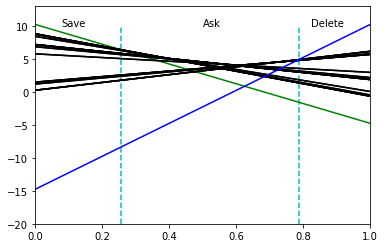

In [75]:
plot_pomdp_utility(utility)